In [1]:
from src.configuration import conf
import tables
import matplotlib.pyplot as plt
import os
import numpy as np

# Basic Data Extraction
Each variable is a time series accross a single game run.

Unintuitve Variables Encodings:
* player_x_target_states:
  * Before comma: Index of current target ant
  * After comma: conquest progress
  * Negative value if there is no current target

* player_x_score_states:
  * Encodes the score popup animation
  * Before comma: Score to show
  * After comma: animation progress
  * Nan if there the popup animation is not shown
   

In [2]:
# Print game course data sets
output_dir_path = os.path.abspath('') + '/' + conf.output_folder_name
records_folder = os.listdir(output_dir_path + '/')
records = []

for name in records_folder:
    path = output_dir_path + '/' + name
    if os.path.isdir(path):
        for file in os.listdir(path):
            #print(name + '/' + file)
            records.append(name + '/' + file)
    else:
        records.append(name)
#records

In [3]:
def file_to_data_dict(file):
    data = file.root.data
        
    general_data = data[:, 0]
    player_data  = data[:,1:3]
    score_data   = data[:, 3]
    ant_data     = data[:,4:]
    
    identifier = str(int(general_data[0, 3])).zfill(3)
    lap = -1
    p0_idx = -1
    p1_idx = -1
    if len(identifier) == 3:
        lap = int(identifier[0])
        p0_idx = int(identifier[1])
        p1_idx = int(identifier[2])
    
    return {
        
        'player_0_scale_factors' : general_data[:, 0],
        'player_1_scale_factors' : general_data[:, 1],
        'timestamps'             : general_data[:, 2],
        
        'player_0_positions' : player_data[:, 0,: 2],
        'player_1_positions' : player_data[:, 1,: 2],

        'player_0_target_states' : player_data[:, 0, 2],
        'player_1_target_states' : player_data[:, 1, 2],
        
        'player_0_pings' : player_data[:, 0, 3],
        'player_1_pings' : player_data[:, 1, 3],

        'player_0_scores' : score_data[:, 0],
        'player_1_scores' : score_data[:, 1],
        
        'player_0_score_state' : score_data[:, 2],
        'player_1_score_state' : score_data[:, 3],

        'ant_x_positions' : ant_data[:,:, 0],
        'ant_y_positions' : ant_data[:,:, 1],
        'ant_kinds'       : ant_data[:,:, 2],
        
        'lap'    : lap,
        'p0_idx' : p0_idx,
        'p1_idx' : p1_idx,
    }

def path_to_data_dict(path):
    output_dir_path = os.path.abspath('') + '/' + conf.output_folder_name
    file = tables.open_file(output_dir_path + path, mode='r')
    return file_to_data_dict(file)
   

path = output_dir_path + '/' + records[-2]
file = tables.open_file(path, mode='r')
game_data = file_to_data_dict(file)
print(path)

/home/brain/uni/pract/dyadic_task/game_records/gs_04-09-21_16-26-11/203.h5


In [4]:
def get_game_data_dicts_for_folder(folder_name):
    output_dir_path = os.path.abspath('') + '/' + conf.output_folder_name + '/' + folder_name
    file_names = os.listdir(output_dir_path)
    table_files = [tables.open_file(output_dir_path + '/' + name, mode='r') for name in file_names]
    return [file_to_data_dict(file) for file in table_files]

retreat_record = get_game_data_dicts_for_folder('gs_02-09-21_18-56-37')
wg_record = get_game_data_dicts_for_folder('gs_04-09-21_16-26-11')


In [5]:
def check_reliability_in_time(timestamps):
    recording_duration = timestamps[-1] - timestamps[0]
    diff = np.zeros(len(timestamps)-1)
    for i in range(len(timestamps)-1):
        diff[i] = timestamps[i+1] - timestamps[i]
    print(f'Actual Value: {recording_duration}')
    print(f'Target Value: {conf.lap_time}')
    print(f'Difference in time mean actual Value: {diff.mean()}')
    print(f'Difference in time mean target Value: {1 / conf.pos_updates_ps}')
    print(f'Difference in time standard derivation: {diff.std()}')
    
    #Actual - Target Value history
    #.89
    #.77 preproduce game_states
    #.45 use exponential moving average improve time scheduling
    #.38 the same as above but no ping requests and no player movement
    #-.02 rewrote server and introduced new game scheduler with own thread,
    # no moving averages or preprocessing requiered!

check_reliability_in_time(game_data['timestamps'])

Actual Value: 299.97820568084717
Target Value: 300
Difference in time mean actual Value: 0.016666381781257136
Difference in time mean target Value: 0.016666666666666666
Difference in time standard derivation: 7.40528192923458e-05


In [6]:
def print_client_field_sizes(game_data):
    print('Initial client field sizes:')
    sf = [game_data['player_0_scale_factors'][0], game_data['player_1_scale_factors'][0]]
    field_server_width, field_server_height = conf.field_size
    print(f'player 1: {int(field_server_width * sf[0])} {int(field_server_height * sf[0])}')
    print(f'player 2: {int(field_server_width * sf[1])} {int(field_server_height * sf[1])}')
    
print_client_field_sizes(game_data)

Initial client field sizes:
player 1: 1774 1053
player 2: 2320 1377


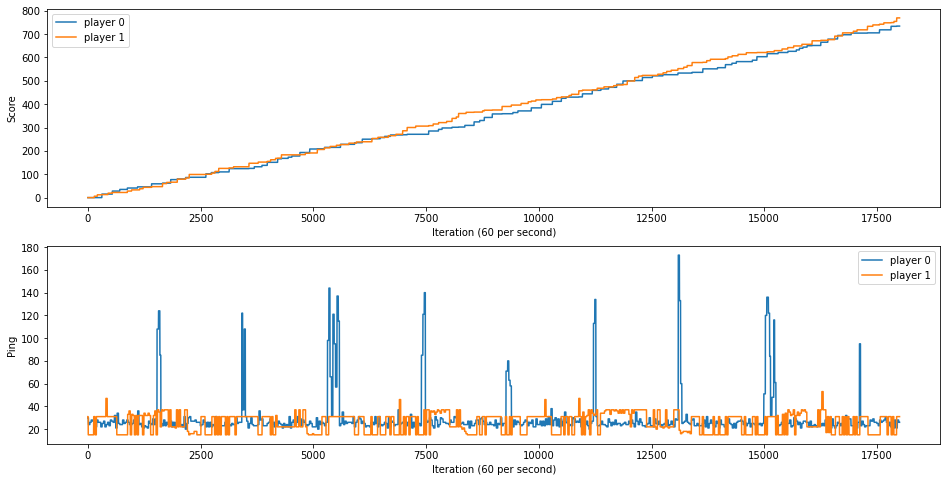

In [7]:
def plot_ping_and_score(game_data):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=((16,8)))
    ax1.set_xlabel(f'Iteration ({conf.pos_updates_ps} per second)')
    ax1.set_ylabel('Score')
    ax1.plot(game_data['player_0_scores'], label='player 0')
    ax1.plot(game_data['player_1_scores'], label='player 1')
    ax1.legend()
    ax2.set_xlabel(f'Iteration ({conf.pos_updates_ps} per second)')
    ax2.set_ylabel('Ping')
    ax2.plot(game_data['player_0_pings'], label='player 0')
    ax2.plot(game_data['player_1_pings'], label='player 1')
    ax2.legend()
    
plot_ping_and_score(game_data)

In [8]:
def vec_ncc(arg_a, arg_b, shift=0):  # a and b should have same length
    a, b = None, None
    if shift >= 0:
        a = arg_a[:len(arg_a)-shift]
        b = arg_b[shift:len(arg_a)]
    else:
        a = arg_a[-1*shift:len(arg_a)]
        b = arg_b[:len(arg_a)+shift]
    a_mean, b_mean = a.mean(0), b.mean(0)
    try:
        normalization_factor = 1/len(a)/(a.std(0).dot(b.std(0)))
        return sum([(a[i]-a_mean).dot(b[i]-b_mean) for i in range(len(a))]) * normalization_factor
    except FloatingPointError as e:
        #print(e)
        #print(f'len(a): {len(a)}')
        #print(f'a.std(0): {a.std(0)}')
        #print(f'b.std(0): {b.std(0)}')
        #print(f'a dot b: {a.std(0).dot(b.std(0))}')
        return 1.
        
    #return sum([(a[i]-a_mean).dot(b[i]-b_mean) for i in range(len(a))]) * normalization_factor
    
def vec_ncc_for_shifts(a, b, shift_dist=10):
    return [vec_ncc(a,b,s) for s in range(-shift_dist,shift_dist+1)]

def best_ncc_shift(a, b, search_dist):
    shifts=list(range(-search_dist,search_dist+1))
    pointer_correlation = vec_ncc_for_shifts(a, b, shift_dist=search_dist)
    max_cor_shift = np.argmax(pointer_correlation) - search_dist
    return max_cor_shift, shifts, pointer_correlation

In [9]:
def frames_to_seconds(frames):
    return [f/conf.pos_updates_ps if f is not None else None for f in frames]

def frames_to_mins(frames):
    return [f/conf.pos_updates_ps/60 if f is not None else None for f in frames]

def plot_cross_correlation(game_data, label):
    p0_pos = game_data['player_0_positions']
    p1_pos = game_data['player_1_positions']
    max_cor_shift, shifts, pointer_correlation_follows = best_ncc_shift(p0_pos, p1_pos, 3 * 60)
    plt.plot(frames_to_seconds(shifts), pointer_correlation_follows, label=label)
    #print(max_cor_shift)

def plot_cross_correltaion_for_folder(folder, title=''):
    output_dir_path = os.path.abspath('') + '/' + conf.output_folder_name + '/' + folder
    file_names = os.listdir(output_dir_path)
    table_files = [tables.open_file(output_dir_path + '/' + name, mode='r') for name in file_names]
    for i in range(len(file_names)):
        plot_cross_correlation(file_to_data_dict(table_files[i]), file_names[i])
    ax = plt.gca()
    ax.set_xlabel('Shifts in Seconds')
    ax.set_ylabel('Normalized Cross Correlation')
    ax.legend(bbox_to_anchor=(1,1), loc='upper left')
    plt.title(title)
    plt.axvline(0, c='k')
    plt.axhline(0, c='k')
    plt.show()

In [22]:
def vec_auto_correlation_for_shifts(a, shifts):
    return [vec_ncc(a,a,s) for s in shifts]

def best_auto_correlation_shift(a, search_dist):
    shifts=list(range(search_dist+1))
    #pointer_correlation = vec_ncc_for_shifts(a, a, shift_dist=search_dist)
    pointer_correlation = vec_auto_correlation_for_shifts(a, shifts)
    max_cor_shift = np.argmax(pointer_correlation) - search_dist
    return max_cor_shift, shifts, pointer_correlation

def plot_auto_correlation(game_data, label):
    p0_pos = game_data['player_0_positions']
    p1_pos = game_data['player_1_positions']
    max_cor_shift, shifts, pointer_correlation_follows = best_auto_correlation_shift(p0_pos, 6 * 60)
    plt.plot(frames_to_seconds(shifts), pointer_correlation_follows, label='player_0_positions_' + label)
    max_cor_shift, shifts, pointer_correlation_follows = best_auto_correlation_shift(p1_pos, 6 * 60)
    plt.plot(frames_to_seconds(shifts), pointer_correlation_follows, label='player_1_positions_' + label)

def plot_auto_correltaion_for_folder(folder, title=''):
    output_dir_path = os.path.abspath('') + '/' + conf.output_folder_name + '/' + folder
    file_names = os.listdir(output_dir_path)
    table_files = [tables.open_file(output_dir_path + '/' + name, mode='r') for name in file_names]
    for i in range(len(file_names)):
        plot_auto_correlation(file_to_data_dict(table_files[i]), file_names[i])
    ax = plt.gca()
    ax.set_xlabel('Shifts in Seconds')
    ax.set_ylabel('Normalized Auto Correlation')
    ax.legend(bbox_to_anchor=(1,1), loc='upper left')
    plt.title(title)
    plt.axvline(0, c='k')
    plt.axhline(0, c='k')
    plt.show()
    
def plot_correltations_for_folder(folder, title=''):
    plot_cross_correltaion_for_folder(folder, title)
    plot_auto_correltaion_for_folder(folder, title)
    


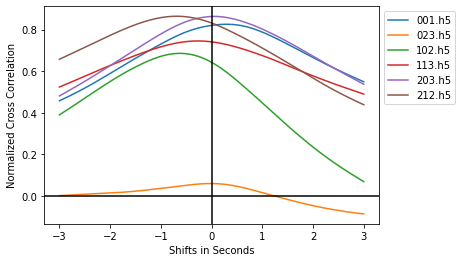

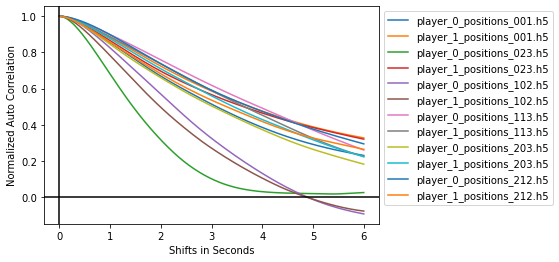

In [23]:
plot_correltations_for_folder(folder='gs_02-09-21_18-56-37',
                              title='')
# shift to left means p0 follows p1

# watched:
# 001 both competition and cooperation, seems like more cooperation in the end
# 023 mostly competition
# 102 played both, a lot of cooperation
# 203 played really cooperative, farmed also grey targets for optimality
# 

# normalized cross correlation got stronger with laps

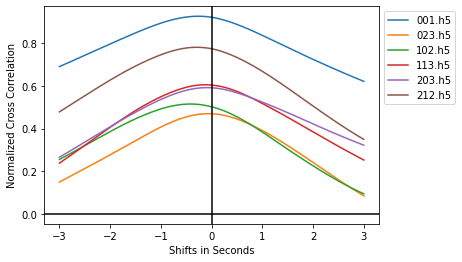

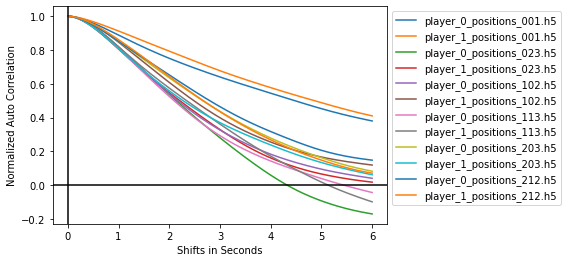

In [42]:
plot_correltations_for_folder(folder='gs_04-09-21_16-26-11',
                              title='')

In [ ]:
plot_correltations_for_folder(folder='records_0',
                              title='20 second recordings with direct mouse control')
plot_correltations_for_folder(folder='records_1',
                              title='60 second recordings with constant speed keyboard/wasd control')
plot_correltations_for_folder(folder='records_2',
                              title='60 second recordings with direct mouse control')

In [13]:
def scored(i, score_states):
    return np.isnan(score_states[i-1]) and not np.isnan(score_states[i])

def get_scorings(game_record):
    p0_ss=game_record['player_0_score_state']
    p1_ss=game_record['player_1_score_state']
    p0_ts=game_record['player_0_target_states']
    p1_ts=game_record['player_1_target_states']
    comp_p0, comp_p1, coop_p0, coop_p1 = [], [], [], []
    for i in range(1,len(p0_ss)):
        if scored(i,p0_ss) and scored(i,p1_ss) and int(p0_ts[i]) == int(p1_ts[i]):
            if p0_ss[i] > p1_ss[i]:
                coop_p0.append(i)
            else:
                coop_p1.append(i)
        else:
            if scored(i,p0_ss):
                comp_p0.append(i)
            if scored(i,p1_ss):
                comp_p1.append(i)
    return comp_p0, comp_p1, coop_p0, coop_p1

In [14]:
def frame_diffs_between_targets(targets, other_targets):
    targets = sorted(targets)
    other_targets = sorted(other_targets)
    last_target = -1
    frame_diffs = []  # first target has no predecessor
    while targets and other_targets:
        if targets[0] < other_targets[0]:
            if last_target != -1:
                frame_diffs.append(targets[0]-last_target)
            else:
                frame_diffs.append(None)
            last_target = targets.pop(0)
        else:
            last_target = -1
            _ = other_targets.pop(0)
    while targets:
        if last_target != -1:
            frame_diffs.append(targets[0]-last_target)
        else:
            frame_diffs.append(None)
        last_target = targets.pop(0)
    return frame_diffs

def avg_sec_between_targets(targets, other_targets):
    frame_diffs = frame_diffs_between_targets(targets, other_targets)
    frame_diffs = list(filter(None, frame_diffs))
    avg_frame_diffs = sum(frame_diffs)/len(frame_diffs)
    return avg_frame_diffs/conf.pos_updates_ps
        
comp_p0, comp_p1, coop_p0, coop_p1 = get_scorings(game_data)
avg_time_between_comp_p0 = avg_sec_between_targets(comp_p0, coop_p0 + coop_p1)
avg_time_between_comp_p1 = avg_sec_between_targets(comp_p1, coop_p0 + coop_p1)
avg_time_between_coop = avg_sec_between_targets(coop_p0 + coop_p1, comp_p0 + comp_p1)
print(avg_time_between_comp_p1)
print(avg_time_between_comp_p0)
print(avg_time_between_coop)
    
    

2.202020202020202
2.6777777777777776
2.92463768115942


In [15]:
def get_player_idx_of_tournament(recordings):
    players = []
    for record in recordings:
        if record['p0_idx'] not in players:
            players.append(record['p0_idx'])
        if record['p1_idx'] not in players:
            players.append(record['p1_idx'])
    return players

def get_player_amount(recordings):
    return 1 + max(get_player_idx_of_tournament(recordings))

def get_lap_amount(recordings):  
    highest_lap = float('-inf')
    for record in recordings:
        if record['lap'] > highest_lap:
            highest_lap = record['lap']
    return highest_lap + 1 # + 1 because lap numeration starts with 0a

def get_lap_frame_amount(recordings):
    return len(recordings[0]['timestamps'])


def flatten_accross_laps(p_occ_lap, record):
    lap_amount = get_lap_amount(record)
    lap_frame_amount = get_lap_frame_amount(record)
    return [t_occ + lap * lap_frame_amount for lap in range(lap_amount) for t_occ in p_occ_lap[lap]]
    

def player_occupations(recordings):
    #print(recordings)
    player_amount = get_player_amount(recordings)
    lap_amount = get_lap_amount(recordings)
    comp_occs = [[None for i in range(lap_amount)] for k in range(player_amount)]
    sb_coop_occs = [[None for i in range(lap_amount)] for k in range(player_amount)]
    kind_coop_occs = [[None for i in range(lap_amount)] for k in range(player_amount)]
    for record in recordings:
        comp_p0, comp_p1, coop_p0, coop_p1 = get_scorings(record)
        comp_occs[record['p0_idx']][record['lap']] = comp_p0
        comp_occs[record['p1_idx']][record['lap']] = comp_p1
        sb_coop_occs[record['p0_idx']][record['lap']] = coop_p0
        sb_coop_occs[record['p1_idx']][record['lap']] = coop_p1
        kind_coop_occs[record['p0_idx']][record['lap']] = coop_p1
        kind_coop_occs[record['p1_idx']][record['lap']] = coop_p0
    occupation_dicts = []
    for p in range(player_amount):
        #player_occ_dict = {'comp':   flatten_accross_laps(comp_occs[p], recordings),
        #                   'coop_sb':flatten_accross_laps(sb_coop_occs[p], recordings),
        #                   'coop_ki':flatten_accross_laps(kind_coop_occs[p], recordings)}
        coop_sb = flatten_accross_laps(sb_coop_occs[p], recordings)
        coop_ki = flatten_accross_laps(kind_coop_occs[p], recordings)
        coop = sorted(coop_sb + coop_ki)
        self_beneficial_coop_idx = []
        kind_coop_idx = []
        for i in range(len(coop)):
            if coop[i] in coop_sb:
                self_beneficial_coop_idx.append(i)
            else:
                kind_coop_idx.append(i)
        player_occ_dict = {'comp': flatten_accross_laps(comp_occs[p], recordings),
                           'coop': coop,
                           'coop_sb': coop_sb,
                           'coop_ki': coop_ki,
                           'kind_coop_idx': kind_coop_idx,
                           'self_beneficial_coop_idx': self_beneficial_coop_idx}
        occupation_dicts.append(player_occ_dict)
    return occupation_dicts

#recordings = get_game_data_dicts_for_folder('gs_02-09-21_18-56-37')
#print(player_occupations(recordings)[0])


In [16]:
def get_occs_and_shift_durations(recordings):
    player_occs = player_occupations(recordings)
    for p in range(len(player_occs)):
        player_occs[p]['shift_dur_comp'] = frame_diffs_between_targets(
            targets=player_occs[p]['comp'],
            other_targets=player_occs[p]['coop'])
        player_occs[p]['shift_dur_coop'] = frame_diffs_between_targets(
            targets=player_occs[p]['coop'],
            other_targets=player_occs[p]['comp'])
    return player_occs

In [24]:
def get_sb_ki_only_coop_list(player_dict):
    coop_sb_only = sorted(player_dict['coop'])
    coop_ki_only = sorted(player_dict['coop'])
    for i in range(len(coop_sb_only)):
        if i not in player_dict['self_beneficial_coop_idx']:
            coop_sb_only[i] = None
        else:
            coop_ki_only[i] = None
    return coop_sb_only, coop_ki_only

def plot_coop_shift_durations(recordings):
    player_occs = get_occs_and_shift_durations(recordings)
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=((16,12)), sharey='col')
    #ax1.set_xlabel(f'Iteration ({conf.pos_updates_ps} per second)')
    #ax1.set_ylabel('Score')
    for i, player_dict in enumerate(player_occs):
        ax1.plot(frames_to_seconds(player_dict['comp']), frames_to_seconds(player_dict['shift_dur_comp']), 'o',label=f'player_{i}')
        coop_sb_only, coop_ki_only = get_sb_ki_only_coop_list(player_dict)
        ax2.plot(frames_to_seconds(coop_sb_only), frames_to_seconds(player_dict['shift_dur_coop']), 'o',label=f'player_{i}')
        ax3.plot(frames_to_seconds(coop_ki_only), frames_to_seconds(player_dict['shift_dur_coop']), 'o',label=f'player_{i}')
        
    #ax1.plot(player_occs[3]['comp'], player_occs[3]['shift_dur_comp'], 'o',label='player 0')
    #ax1.plot(game_data['player_1_scores'], label='player 1')
    ax1.legend()
    ax2.legend()
    ax3.legend()
    
    
#plot_coop_shift_durations(retreat_record)
#plot_coop_shift_durations(wg_record)

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

def plot_player_occ_times(recordings):
    player_occs = get_occs_and_shift_durations(recordings)
    player_amount = get_player_amount(recordings)
    fig, axis = plt.subplots(nrows=player_amount, ncols=1, figsize=((16,4*player_amount)),sharey='col')
    axis = list(axis)
    for i, player_dict in enumerate(player_occs):
        axis[i].plot(player_dict['comp'], player_dict['shift_dur_comp'],
                     color=rgb_to_hex(conf.competitive_reward_color), marker='o', linestyle='',
                     label='competitive_occupations')
        
        
    #ax1.plot(player_occs[3]['comp'], player_occs[3]['shift_dur_comp'], 'o',label='player 0')
    #ax1.plot(game_data['player_1_scores'], label='player 1')
    for ax in axis:
        ax.legend()
    
#plot_player_occ_times(recordings)

In [18]:
recordings = None

#def get_coop_frac_window(recordings, window):
#    player_occs = get_occs_and_shift_durations(recordings)
#    frame_amount = get_lap_amount(recordings) * get_lap_frame_amount(recordings)
#    coop_occ_timings = []
#    comp_occ_timings = []
#    for player_dict in player_occs:
#        coop_occ_timings.extend(player_dict['coop_sb'])
#        comp_occ_timings.extend(player_dict['comp'])
#    coop_frac = [0 for _ in range(window)]
#    for i in range(window, frame_amount):
#        coop_count = 0
#        comp_count = 0
#        for timing in coop_occ_timings:
#            if i - window < timing <= i:
#                coop_count += 2
#        for timing in comp_occ_timings:
#            if i - window < timing <= i:
#                comp_count += 1
#        coop_frac.append(coop_count/(coop_count+comp_count))
#    print(coop_frac[-1])
#    return coop_frac

def get_coop_frac_window(record, window):
    comp_p0, comp_p1, coop_p0, coop_p1 = get_scorings(record)
    comp = comp_p0 + comp_p1
    coop = coop_p0 + coop_p1
    frame_amount = len(record['timestamps'])
    coop_frac = [None for _ in range(window)]
    for i in range(window, frame_amount):
        frames = set(range(i - window, i + 1))
        comp_count = len(frames.intersection(comp))
        coop_count = len(frames.intersection(coop))
        if comp_count + coop_count != 0:
            coop_frac.append(coop_count/(coop_count+comp_count))
        else:
            coop_frac.append(None)
    return coop_frac

def flatten_accross_laps(p_occ_lap, record):
    lap_amount = get_lap_amount(record)
    lap_frame_amount = get_lap_frame_amount(record)
    return [t_occ + lap * lap_frame_amount for lap in range(lap_amount) for t_occ in p_occ_lap[lap]]

def plot_coop_fracs(recordings, window):
    fig, axis = plt.subplots(nrows=len(recordings), ncols=1, figsize=((16,4*len(recordings))), sharey='col')
    for i, record in enumerate(recordings):
        coop_frac = get_coop_frac_window(record, window)
        axis[i].plot(frames_to_mins(list(range(len(coop_frac)))), coop_frac)

def get_coop_frac_window_for_player(recordings, window):
    player_amount = get_player_amount(recordings)
    lap_amount = get_lap_amount(recordings)
    player_coop_frac = [[None for _ in range(lap_amount)] for _ in range(player_amount)]
    for record in recordings:
        coop_frac = get_coop_frac_window(record, window)
        lap = record['lap']
        p0 = record['p0_idx']
        p1 = record['p1_idx']
        player_coop_frac[p0][lap] = coop_frac
        player_coop_frac[p1][lap] = coop_frac
    return [sum(p_coop_frac, []) for p_coop_frac in player_coop_frac]

def get_tournament_frame_amount(recordings):
    return get_lap_amount(recordings) * get_lap_frame_amount(recordings)
    

def plot_coop_fracs_for_player(recordings, window):
    player_amount = get_player_amount(recordings)
    frames = list(range(get_tournament_frame_amount(recordings)))
    fig, axis = plt.subplots(nrows=player_amount, ncols=1, figsize=((16,4*player_amount)), sharey='col')
    coop_fracs = get_coop_frac_window_for_player(recordings, window)
    lines = []
    for p in range(player_amount):
        lines.append(axis[p].plot(frames_to_mins(frames), coop_fracs[p])[0])
    return lines

from matplotlib.widgets import Slider
        
def interactive_ma_coop_frac_for_player(recordings, windows=[10, 30, 60]):
    %matplotlib tk
    frames = list(range(get_tournament_frame_amount(recordings)))
    coop_fracs_for_win = [get_coop_frac_window_for_player(recordings, w) for w in windows]
    player_amount = get_player_amount(recordings)
    fig, axis = plt.subplots(nrows=player_amount, ncols=1, figsize=((16,4*player_amount)), sharey='col')
    ma_slider = Slider(
        ax=plt.axes([0.25, 0.1, 0.65, 0.03]),
        label='Moving average window in seconds',
        valmin=10,
        valmax=60,
        valstep=np.array(windows),
        valinit=30)
    for p in range(player_amount):
        axis[p].plot(frames_to_mins(frames), coop_fracs_for_win[2][p])
    def update(val):
        print(val)
        #l.set_ydata(amp*np.sin(2*np.pi*freq*t))
        for p in range(player_amount):
            axis[p].plot(frames_to_mins(frames), coop_fracs_for_win[val][p])
        fig.canvas.draw_idle()
    ma_slider.on_changed(update)
    plt.show()

In [75]:
import matplotlib.ticker as mtick

def show_ma_coop_fracs(recordings, coop_fracs_for_win, windows):
    %matplotlib tk
    init_start_win_inx = 9
    
    #plt.figure()
    player_amount = get_player_amount(recordings)
    lap_frame_amount = get_lap_frame_amount(recordings)
    frames = list(range(get_tournament_frame_amount(recordings)))

    fig, axis = plt.subplots(nrows=player_amount, ncols=1, figsize=((16,4*player_amount)), sharey='col')
    plt.subplots_adjust(bottom=0.20)
    axis[0].set_title(f'Moving average ({windows[init_start_win_inx]} seconds) over share of cooperative catches', fontsize=15)
    axis[-1].set_xlabel('Minute of recording', fontsize=12)
    lines = []
    colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c']
    for p in range(player_amount):
        lines.append(axis[p].plot(frames_to_mins(frames),
                                  coop_fracs_for_win[init_start_win_inx][p],
                                  c=colors[p],
                                  linewidth=3,
                                  label=f'player {p}')[0])
        axis[p].legend(bbox_to_anchor=(0,1), loc='upper left')
        axis[p].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
        #for i in range(get_lap_amount(recordings)):
        #    axis[p].axvline(i*lap_frame_amount)

    ma_slider = Slider(
        ax=plt.axes([0.40, 0.1, 0.2, 0.03]),
        label='MA window in secs',
        valmin=windows[0],
        valmax=windows[-1],
        valstep=np.array(windows),
        valinit=windows[init_start_win_inx])

    def update(val):
        w = windows.index(val)
        for p in range(player_amount):
            lines[p].set_ydata(coop_fracs_for_win[w][p])
        fig.canvas.draw_idle()
        axis[0].set_title(f'Moving average ({val} seconds) over share of cooperative catches', fontsize=15)

    ma_slider.on_changed(update)
    plt.show()
    return ma_slider

In [36]:
windows = [3+2*i for i in range(6)] + [15+5*i for i in range(11)]
coop_fracs_for_win_wg = [get_coop_frac_window_for_player(wg_record, w * conf.pos_updates_ps) for w in windows]

In [81]:
_ = show_ma_coop_fracs(wg_record, coop_fracs_for_win_wg, windows)

In [77]:
coop_fracs_for_win_retreat = [get_coop_frac_window_for_player(retreat_record, w * conf.pos_updates_ps) for w in windows]

In [83]:
_ = show_ma_coop_fracs(retreat_record, coop_fracs_for_win_retreat, windows)